In [2]:
!pip install onnxscript onnxruntime tensorflow tensorflow-model-optimization tf_keras wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 683.0/683.0 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 73.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 66.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.3/129.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source 

5. The humidity precision: typical ± 2%

6. Humidity resolution: 0.024%

7. Temperature accuracy: typical ± 0.3℃

8. Temperature resolution: typical 0.01℃

9. The operating temperature: -40 ℃-85 ℃

In [1]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = "1"

In [2]:
import tensorflow as tf
import tensorflow_model_optimization as tfmot
import numpy as np
import pandas as pd
import wandb


In [ ]:
!wandb login


In [ ]:
run = wandb.init(
    project="your_project_name",
    config={
        "data_samples":6000,
        "batch_size": 32,
        "architecture":"two_layer_relu_activation",
        "layer_01":8,
        "layer_02":16,
        "epochs": 30
    },
)

config = wandb.config

wandb: Currently logged in as: yasantha-21 (eml-labs) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
np.random.seed(42)

In [ ]:
num_samples = config.data_samples

# Temperature: 26.7 to 50 °C
temperature = np.round(np.random.uniform(26.7, 40, num_samples), 2)

# Humidity: 40% to 100 %
humidity = np.round(np.random.uniform(40, 100, num_samples), 2)

# Combine into a DataFrame
data = pd.DataFrame({
    'temp_C': temperature,
    'temp_F': np.round((temperature * 9/5) + 32,2),
    'hum': humidity
})

In [ ]:
data.head()

,temp_C,temp_F,hum
0,31.68,89.02,78.90
1,39.34,102.81,50.34
2,36.44,97.59,92.34
3,34.66,94.39,76.79
4,28.78,83.80,49.43


In [7]:
def heat_index(T, RH):
    HI = (-42.379 + 2.04901523*T + 10.14333127*RH - 0.22475541*T*RH
          - 0.00683783*T*T - 0.05481717*RH*RH + 0.00122874*T*T*RH
          + 0.00085282*T*RH*RH - 0.00000199*T*T*RH*RH)
    return HI

In [ ]:
data['h_index'] = np.round((heat_index(data['temp_F'], data['hum']) - 32)*5/9,2)

In [ ]:
data.head()

,temp_C,temp_F,hum,h_index
0,31.68,89.02,78.90,42.77
1,39.34,102.81,50.34,52.88
2,36.44,97.59,92.34,73.86
3,34.66,94.39,76.79,53.04
4,28.78,83.80,49.43,29.31


In [ ]:
print(data['h_index'].max(), data['h_index'].min())

105.72 26.79


In [ ]:
from tensorflow.keras.callbacks import Callback
import wandb

class WandbLogger(Callback):
    def __init__(self, model_type="normal"):
        super().__init__()
        self.model_type = model_type  # "normal" or "quantized"

    def on_epoch_end(self, epoch, logs=None):
        """
        logs: dictionary containing metrics like {'loss':..., 'mae':..., 'val_loss':..., 'val_mae':...}
        """
        if logs is not None:
            log_data = {f"{self.model_type}_{k}": float(v) for k, v in logs.items()}
            wandb.log(log_data, step=epoch)


In [ ]:
from sklearn.model_selection import train_test_split

# Features and target
X = data[['temp_C', 'hum']]
y = data['h_index']

# Split into train (60%), validation (20%), test (20%) in one go
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Now split the remaining 80% into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42  # 0.25 * 0.8 = 0.2
)

print(f"Train size: {len(X_train)}, Val size: {len(X_val)}, Test size: {len(X_test)}")

Train size: 3600, Val size: 1200, Test size: 1200


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1,1))
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1,1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1,1))

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_train_scaled)).batch(config.batch_size).shuffle(500)
val_ds = tf.data.Dataset.from_tensor_slices((X_val_scaled, y_val_scaled)).batch(config.batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((X_test_scaled, y_test_scaled)).batch(config.batch_size)

In [42]:

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    tf.keras.layers.Dense(config.layer_01, activation='relu'),
    tf.keras.layers.Dense(config.layer_02, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(optimizer='adam', loss='mse', metrics=['mae','mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 24        
                                                                 
 dense_1 (Dense)             (None, 16)                144       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 185 (740.00 Byte)
Trainable params: 185 (740.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# -------------------------------
quantize_model = tfmot.quantization.keras.quantize_model
qat_model = quantize_model(model)

qat_model.compile(optimizer='adam', loss='mse', metrics=['mae','mse'])
qat_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLa  (None, 2)                 3         
 yer)                                                            
                                                                 
 quant_dense (QuantizeWrapp  (None, 8)                 29        
 erV2)                                                           
                                                                 
 quant_dense_1 (QuantizeWra  (None, 16)                149       
 pperV2)                                                         
                                                                 
 quant_dense_2 (QuantizeWra  (None, 1)                 22        
 pperV2)                                                         
                                                                 
Total params: 203 (812.00 Byte)
Trainable params: 185 (7

In [ ]:
for layer in qat_model.layers:
    if hasattr(layer, "non_trainable_variables"):
        if layer.non_trainable_variables:
            print(f"\n{layer.name}")
            for v in layer.non_trainable_variables:
                print(" ", v.name, v.shape, v.numpy())


quantize_layer
  quantize_layer/quantize_layer_min:0 () 0.0
  quantize_layer/quantize_layer_max:0 () 0.0
  quantize_layer/optimizer_step:0 () -1

quant_dense
  quant_dense/optimizer_step:0 () -1
  quant_dense/kernel_min:0 () -6.0
  quant_dense/kernel_max:0 () 6.0
  quant_dense/post_activation_min:0 () -6.0
  quant_dense/post_activation_max:0 () 6.0

quant_dense_1
  quant_dense_1/optimizer_step:0 () -1
  quant_dense_1/kernel_min:0 () -6.0
  quant_dense_1/kernel_max:0 () 6.0
  quant_dense_1/post_activation_min:0 () -6.0
  quant_dense_1/post_activation_max:0 () 6.0

quant_dense_2
  quant_dense_2/optimizer_step:0 () -1
  quant_dense_2/kernel_min:0 () -6.0
  quant_dense_2/kernel_max:0 () 6.0
  quant_dense_2/post_activation_min:0 () -6.0
  quant_dense_2/post_activation_max:0 () 6.0


In [ ]:
qat_logger = WandbLogger(model_type="quantized")
qat_model.fit(train_ds, validation_data=val_ds, epochs=30,callbacks=[qat_logger])

Epoch 1/30
113/113 [==============================] - 2s 6ms/step - loss: 0.0223 - mae: 0.1084 - mse: 0.0223 - val_loss: 0.0091 - val_mae: 0.0717 - val_mse: 0.0091
Epoch 2/30
113/113 [==============================] - 0s 2ms/step - loss: 0.0064 - mae: 0.0592 - mse: 0.0064 - val_loss: 0.0035 - val_mae: 0.0436 - val_mse: 0.0035
Epoch 3/30
113/113 [==============================] - 0s 3ms/step - loss: 0.0030 - mae: 0.0420 - mse: 0.0030 - val_loss: 0.0022 - val_mae: 0.0342 - val_mse: 0.0022
Epoch 4/30
113/113 [==============================] - 0s 2ms/step - loss: 0.0017 - mae: 0.0303 - mse: 0.0017 - val_loss: 0.0013 - val_mae: 0.0266 - val_mse: 0.0013
Epoch 5/30
113/113 [==============================] - 0s 3ms/step - loss: 0.0011 - mae: 0.0240 - mse: 0.0011 - val_loss: 9.4378e-04 - val_mae: 0.0232 - val_mse: 9.4378e-04
Epoch 6/30
113/113 [==============================] - 0s 3ms/step - loss: 7.5755e-04 - mae: 0.0204 - mse: 7.5755e-04 - val_loss: 6.6471e-04 - val_mae: 0.0197 - val_mse: 6.6

In [ ]:
normal_logger = WandbLogger(model_type="normal")
model.fit(train_ds, validation_data=val_ds, epochs=30,callbacks=[normal_logger])

Epoch 1/30
113/113 [==============================] - 3s 11ms/step - loss: 0.0221 - mae: 0.1081 - mse: 0.0221 - val_loss: 0.0092 - val_mae: 0.0697 - val_mse: 0.0092
Epoch 2/30
113/113 [==============================] - 1s 6ms/step - loss: 0.0064 - mae: 0.0583 - mse: 0.0064 - val_loss: 0.0034 - val_mae: 0.0438 - val_mse: 0.0034
Epoch 3/30
113/113 [==============================] - 1s 7ms/step - loss: 0.0027 - mae: 0.0393 - mse: 0.0027 - val_loss: 0.0017 - val_mae: 0.0320 - val_mse: 0.0017
Epoch 4/30
 93/113 [=======================>......] - ETA: 0s - loss: 0.0013 - mae: 0.0263 - mse: 0.0013

wandb: WARNING Tried to log to step 0 that is less than the current step 29. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 1 that is less than the current step 29. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


 99/113 [=========================>....] - ETA: 0s - loss: 0.0013 - mae: 0.0260 - mse: 0.0013

wandb: WARNING Tried to log to step 2 that is less than the current step 29. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


113/113 [==============================] - 1s 7ms/step - loss: 0.0013 - mae: 0.0255 - mse: 0.0013 - val_loss: 9.0012e-04 - val_mae: 0.0208 - val_mse: 9.0012e-04
Epoch 5/30
113/113 [==============================] - 1s 8ms/step - loss: 6.8832e-04 - mae: 0.0174 - mse: 6.8832e-04 - val_loss: 5.6510e-04 - val_mae: 0.0166 - val_mse: 5.6510e-04
Epoch 6/30
113/113 [==============================] - 1s 5ms/step - loss: 4.6434e-04 - mae: 0.0147 - mse: 4.6434e-04 - val_loss: 4.2737e-04 - val_mae: 0.0146 - val_mse: 4.2737e-04
Epoch 7/30
113/113 [==============================] - 1s 10ms/step - loss: 3.7063e-04 - mae: 0.0136 - mse: 3.7063e-04 - val_loss: 3.2440e-04 - val_mae: 0.0127 - val_mse: 3.2440e-04
Epoch 8/30
113/113 [==============================] - 1s 9ms/step - loss: 3.2313e-04 - mae: 0.0130 - mse: 3.2313e-04 - val_loss: 2.9757e-04 - val_mae: 0.0130 - val_mse: 2.9757e-04
Epoch 9/30
113/113 [==============================] - 1s 8ms/step - loss: 2.9032e-04 - mae: 0.0124 - mse: 2.9032e-04 -

wandb: WARNING Tried to log to step 3 that is less than the current step 29. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 4 that is less than the current step 29. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 5 that is less than the current step 29. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


 62/113 [===============>..............] - ETA: 0s - loss: 1.4893e-04 - mae: 0.0094 - mse: 1.4893e-04

wandb: WARNING Tried to log to step 6 that is less than the current step 29. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 7 that is less than the current step 29. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 8 that is less than the current step 29. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 9 that is less than the current step 29. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 10 that is less than the current step 29. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me

113/113 [==============================] - 0s 3ms/step - loss: 1.4581e-04 - mae: 0.0093 - mse: 1.4581e-04 - val_loss: 1.3184e-04 - val_mae: 0.0086 - val_mse: 1.3184e-04
Epoch 18/30
113/113 [==============================] - 0s 2ms/step - loss: 1.3870e-04 - mae: 0.0089 - mse: 1.3870e-04 - val_loss: 1.3116e-04 - val_mae: 0.0093 - val_mse: 1.3116e-04
Epoch 19/30
113/113 [==============================] - 0s 2ms/step - loss: 1.3117e-04 - mae: 0.0087 - mse: 1.3117e-04 - val_loss: 1.2278e-04 - val_mae: 0.0086 - val_mse: 1.2278e-04
Epoch 20/30
113/113 [==============================] - 0s 2ms/step - loss: 1.3018e-04 - mae: 0.0087 - mse: 1.3018e-04 - val_loss: 1.1315e-04 - val_mae: 0.0082 - val_mse: 1.1315e-04
Epoch 21/30
113/113 [==============================] - 0s 2ms/step - loss: 1.2000e-04 - mae: 0.0083 - mse: 1.2000e-04 - val_loss: 1.2742e-04 - val_mae: 0.0086 - val_mse: 1.2742e-04
Epoch 22/30
113/113 [==============================] - 0s 2ms/step - loss: 1.1728e-04 - mae: 0.0082 - mse: 

In [ ]:
loss, mae,mse = qat_model.evaluate(test_ds)
print(f"Test MAE: {mae} | Test MSE: {mse}")
wandb.log({"quantized_model_test_mae":mae,"quantized_model_test_mse":mse})

38/38 [==============================] - 0s 2ms/step - loss: 6.9825e-05 - mae: 0.0065 - mse: 6.9825e-05
Test MAE: 0.0064596571028232574 | Test MSE: 6.982492777751759e-05


In [ ]:
loss,mae,mse = model.evaluate(test_ds)
print(f"Test MAE: {mae} | Test MSE: {mse}")
wandb.log({"normal_model_test_mae":mae,"normal_model_test_mse":mse})

38/38 [==============================] - 0s 1ms/step - loss: 8.6287e-05 - mae: 0.0077 - mse: 8.6287e-05
Test MAE: 0.007661373820155859 | Test MSE: 8.628746581962332e-05


In [ ]:
model.save("normal_model.h5")
qat_model.save("qat_model.h5")


/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
def representative_data_gen():
    for input_value, _ in train_ds.take(1000):
        # Convert to float32
        yield [tf.cast(input_value, tf.float32)]

converter = tf.lite.TFLiteConverter.from_keras_model(qat_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

In [ ]:
tflite_model = converter.convert()

with open("qat_model_uint8.tflite", "wb") as f:
    f.write(tflite_model)

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [ ]:
orig_artifact = wandb.Artifact(
    name="original_model",
    type="model",
    description="Original trained float32 model"
)
orig_artifact.add_file("normal_model.h5")
wandb.log_artifact(orig_artifact)

qat_artifact = wandb.Artifact(
    name="qat_model",
    type="model",
    description="Quantization-Aware Training (QAT) trained model"
)
qat_artifact.add_file("qat_model.h5")
wandb.log_artifact(qat_artifact)

quant_artifact = wandb.Artifact(
    name="quantized_model",
    type="model",
    description="Fully quantized TFLite model"
)
quant_artifact.add_file("qat_model_uint8.tflite")
wandb.log_artifact(quant_artifact)


wandb: WARNING Tried to log to step 16 that is less than the current step 29. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 17 that is less than the current step 29. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 18 that is less than the current step 29. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 19 that is less than the current step 29. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 20 that is less than the current step 29. Steps must be monotonically increasing, so this data will be ignored. See https://wand

<Artifact quantized_model>

In [ ]:
# --- 1. Generate random samples ---
num_samples = 1000
temperature = np.round(np.random.uniform(26.7, 40, num_samples), 2)  # °C
humidity = np.round(np.random.uniform(40, 100, num_samples), 2)      # %
# Convert to Fahrenheit for heat index formula
temperature_F = np.round(temperature * 9/5 + 32, 2)

# --- 2. Original heat index calculation --

ground_truth = np.round((heat_index(temperature_F, humidity) - 32)*5/9,2)
# print("Ground-truth heat index:", ground_truth)

In [ ]:

# --- 3. Load TFLite model ---
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


In [ ]:
print(input_details)
print(output_details)

[{'name': 'serving_default_input_13:0', 'index': 0, 'shape': array([1, 2], dtype=int32), 'shape_signature': array([-1,  2], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.003921568859368563, -128), 'quantization_parameters': {'scales': array([0.00392157], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'StatefulPartitionedCall:0', 'index': 9, 'shape': array([1, 1], dtype=int32), 'shape_signature': array([-1,  1], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.004518874920904636, -83), 'quantization_parameters': {'scales': array([0.00451887], dtype=float32), 'zero_points': array([-83], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [ ]:
# For temperature and humidity
temp_min, hum_min = scaler_X.data_min_      # min values for each column
temp_max, hum_max = scaler_X.data_max_      # max values for each column

In [ ]:
print(f"temp min: {temp_min}, temp max: {temp_max}")
print(f"hum min: {hum_min}, hum max: {hum_max}")

temp min: 26.7, temp max: 40.0
hum min: 40.01, hum max: 99.98


In [ ]:
temp_range = temp_max - temp_min
hum_range = hum_max - hum_min
print(f"temp range: {temp_range}, hum range: {hum_range}")

temp range: 13.3, hum range: 59.970000000000006


In [ ]:
scaler_max = scaler_y.data_max_
scaler_min = scaler_y.data_min_
print(f"scaler max: {scaler_max}, scaler min: {scaler_min}")
print(f"range : {scaler_max - scaler_min}")

scaler max: [105.72], scaler min: [26.79]
range : [78.93]


In [ ]:

# --- 4. Run inference on TFLite model ---
tflite_preds = []
for t, h in zip(temperature, humidity):
    # Normalize a new sample (t,h)
    t_norm = (t - temp_min) / (temp_max - temp_min)
    h_norm = (h - hum_min) / (hum_max - hum_min)

    input_data = np.array([[t_norm, h_norm]], dtype=np.float32)
    # If your model was converted to int8, scale and cast:
    if input_details[0]['dtype'] == np.int8:
        scale, zero_point = input_details[0]['quantization']
        input_data = input_data / scale + zero_point
        input_data = input_data.astype(np.int8)

    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])

    # If output is quantized, dequantize
    if output_details[0]['dtype'] == np.int8:
        scale, zero_point = output_details[0]['quantization']
        output_data = scale * (output_data.astype(np.float32) - zero_point)
    # To convert model output back to original heat index
    hi_pred_scaled = output_data   # output from TFLite (float or dequantized)
    hi_pred = hi_pred_scaled * (scaler_y.data_max_ - scaler_y.data_min_) + scaler_y.data_min_
    tflite_preds.append(hi_pred.squeeze())

# tflite_preds = np.array(tflite_preds)
# print("TFLite model predictions:", tflite_preds)

# # --- 5. Compare results ---
# for i in range(num_samples):
#     print(f"Sample {i}: Temp={temperature[i]}°C, Hum={humidity[i]}% | "
#           f"Ground-truth={ground_truth[i]:.2f}, TFLite={tflite_preds[i]:.2f}")

In [ ]:
rmse = np.sqrt(np.mean((ground_truth - tflite_preds) ** 2))
print(f"RMSE : {rmse:.2f}")
wandb.log({"rmse":rmse})

RMSE : 0.70


In [ ]:
wandb.finish()

normal_loss,▁
normal_mae,▁
normal_model_test_mae,▁
normal_model_test_mse,▁
normal_mse,▁
normal_val_loss,▁
normal_val_mae,▁
normal_val_mse,▁
quantized_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
quantized_mae,█▅▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
+7,...


In [ ]:
t = 28.39
h = 64.68
# Normalize a new sample (t,h)
t_norm = (t - temp_min) / (temp_max - temp_min)
h_norm = (h - hum_min) / (hum_max - hum_min)

input_data = np.array([[t_norm, h_norm]], dtype=np.float32)
# If your model was converted to uint8, scale and cast:
if input_details[0]['dtype'] == np.int8:
    scale, zero_point = input_details[0]['quantization']
    input_data = input_data / scale + zero_point
    input_data = input_data.astype(np.int8)
    print(input_data)

interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)
# If output is quantized, dequantize
if output_details[0]['dtype'] == np.int8:
    scale, zero_point = output_details[0]['quantization']
    output_data = scale * (output_data.astype(np.float32) - zero_point)
# To convert model output back to original heat index
hi_pred_scaled = output_data   # output from TFLite (float or dequantized)
hi_pred = hi_pred_scaled * (scaler_y.data_max_ - scaler_y.data_min_) + scaler_y.data_min_

[[-95 -23]]
[[-73]]


In [ ]:
print(hi_pred)

[[30.35674783]]


In [3]:
df = pd.read_csv('/content/output.txt')

In [4]:
df.head()

,Temp,Hum,Output,Time_us
0,36.64,80.46,63.88418,32.96
1,28.39,64.68,30.35675,67.67
2,33.08,46.85,35.35020,42.58
3,30.58,45.07,31.07010,37.92
4,36.04,43.35,40.70032,28.00


In [5]:
temp = np.array(df['Temp'])
hum = np.array(df['Hum'])
temp_f = temp

In [8]:
h_index = heat_index(temp_f, hum)
print(h_index)

[139.90104066 182.9489134  144.6260854  150.91009569 130.23050657
 164.43018407 155.33959066 162.82987076 120.3275308  151.99018044
 132.25142468 163.61384712 130.08616104 136.66432388 168.28896357
 146.97262476 167.10816403 117.48005854 141.60410714 126.63891572
 162.84931901 177.79928702 169.04485893 185.08496739 178.38101591
 161.39622482 163.52426282 137.58872417 150.07628039 161.95551452
 191.3291883  144.60677791 132.09170127 188.34727845 169.76401489
 136.39720246 158.52188992 164.67174567 133.79081184 177.12983829
 142.51125713 115.78011854 161.40980995 130.33336327 144.16742359
 161.11998718 109.03683466 163.25711769 159.78996767 139.99032414
 175.78686804 167.16684403 171.02078514 117.27526638 152.80908825
 147.30915476 167.46110402 145.18479015 157.43791782 151.08261553
 185.46061811 129.88100147 154.51254218 141.57971129 169.60995732
 140.07128307 190.87063898 149.31961173 119.4046773  125.58495007
 168.58599437 182.77928592 131.20761537 184.90284164 138.01866303
 134.25811

In [9]:
h_index_C = np.round((h_index - 32)*5/9,5)

In [17]:
output = np.round((np.array(df['Output'])),2)
print(output)

[ 63.88  30.36  35.35  31.07  40.7   28.22  36.42  32.5   81.36  53.18
  36.42  30.36  71.37  46.05  31.43  41.06  42.13  92.42  55.32  81.
  34.28  34.28  38.92  31.43  35.35  46.41  32.5   61.39  49.26  27.5
  28.93  35.71  42.48  31.07  27.86  42.84  27.86  42.48  61.39  28.57
  58.53  91.35  34.64  74.58  34.28  45.69  95.63  44.62  29.64  62.1
  30.36  40.7   39.27  83.14  52.11  53.18  36.06  55.32  34.99  46.76
  28.93  73.87  48.19  57.11  39.99  62.46  30.36  54.97  45.34  82.43
  40.7   27.86  63.17  27.5   58.18  67.45  50.33  37.49  40.34  38.2
  54.25  33.57  65.31  46.76  45.34  57.82  88.14  47.48  28.57  41.77
  51.76  43.91  34.28  46.41  57.11  58.89  63.53  34.99  53.54  43.55
  42.13  39.63  70.3   42.84  59.96  28.93  55.68  66.38  40.34  42.48
  73.16  70.66  51.04  38.92  29.29  41.77  89.21  54.25  28.93  32.85
  77.79  34.64  34.99  68.88  29.64  28.57  30.71  57.11  47.12  38.56
  78.15  28.57  85.64  37.13  28.93  33.57  28.93  39.63  83.14  71.73
  58.18  30

In [11]:
print(h_index_C)

[59.94502 83.86051 62.57005 66.06116 54.5725  73.57232 68.52199 72.68326
 49.07085 66.66121 55.69524 73.1188  54.49231 58.14685 75.71609 63.87368
 75.06009 47.48892 60.89117 52.57718 72.69407 80.9996  76.13603 85.0472
 81.32279 71.88679 73.06903 58.6604  65.59793 72.19751 88.51622 62.55932
 55.6065  86.8596  76.53556 57.99845 70.28994 73.70653 56.55045 80.62769
 61.39514 46.54451 71.89434 54.62965 62.31524 71.73333 42.79824 72.92062
 70.99443 59.99462 79.88159 75.09269 77.23377 47.37515 67.11616 64.06064
 75.25617 62.88044 69.68773 66.15701 85.2559  54.37833 68.06252 60.87762
 76.44998 60.0396  88.26147 65.17756 48.55815 51.99164 75.88111 83.76627
 55.11534 84.94602 58.89926 56.81006 68.841   70.02871 74.11349 54.41669
 57.27834 76.17715 59.1289  59.53635 71.73226 60.84997 49.02757 70.71113
 63.46732 75.55687 55.54797 51.42766 58.0036  68.98866 58.86359 62.66441
 56.4973  77.07133 66.29878 67.50028 72.79457 76.78038 57.01435 65.04172
 60.26224 86.43055 63.73454 58.96522 68.56435 74.011

In [19]:
rms = np.sqrt(np.mean((h_index_C - output) ** 2))
print(rms)

32.916634831357115


In [48]:
import numpy as np
import pandas as pd

df_normal = pd.read_csv("output_normal.txt")
df_npu = pd.read_csv("output.txt")
df_model = pd.read_csv("output_model.txt")

In [49]:
df_normal.head()

,Temp,Hum,Output,Time_us
0,97.95,80.46,148.38054,3.21
1,83.10,64.68,87.19594,2.04
2,91.54,46.85,96.02844,1.17
3,87.04,45.07,87.99782,0.58
4,96.87,43.35,104.82140,0.58


In [50]:
df_normal['Temp'] = np.round((df_normal['Temp'] -32)*5/9,2)
df_normal['Output'] = np.round((df_normal['Output'] -32)*5/9,2)

In [34]:
df_normal.head()

,Temp,Hum,Output,Time_us
0,36.64,80.46,64.66,3.21
1,28.39,64.68,30.66,2.04
2,33.08,46.85,35.57,1.17
3,30.58,45.07,31.11,0.58
4,36.04,43.35,40.46,0.58


In [51]:
df_npu.head()

,Temp,Hum,Output,Time_us
0,36.64,80.46,63.88418,32.96
1,28.39,64.68,30.35675,67.67
2,33.08,46.85,35.35020,42.58
3,30.58,45.07,31.07010,37.92
4,36.04,43.35,40.70032,28.00


In [52]:
df_model.head()

,Temp,Hum,Output,Time_us
0,36.64,80.46,64.48357,16.33
1,28.39,64.68,30.18338,10.21
2,33.08,46.85,35.44123,8.46
3,30.58,45.07,31.10279,7.58
4,36.04,43.35,40.73565,7.88


In [53]:
normal_output = np.array(df_normal['Output'])
npu_output = np.array(df_npu['Output'])
model_output = np.array(df_model['Output'])

print(f"RMSE Between Equation and NPU Computation- {np.sqrt(np.mean((normal_output - npu_output)**2))}")
print(f"RMSE Between Equation and Model Computation- {np.sqrt(np.mean((normal_output - model_output)**2))}")

RMSE Between Equation and NPU Computation- 0.38917809047324353
RMSE Between Equation and Model Computation- 0.29979180244713177


In [54]:
time_us_normal = np.array(df_normal["Time_us"])
time_us_npu = np.array(df_npu["Time_us"])
time_us_model = np.array(df_model["Time_us"])

In [56]:
print(f"Mean Time for Equation- {np.mean(time_us_normal)} us")
print(f"Mean Time for NPU- {np.mean(time_us_npu)} us")
print(f"Mean Time for Model- {np.mean(time_us_model)} us")

Mean Time for Equation- 0.6389400000000001 us
Mean Time for NPU- 26.245479999999997 us
Mean Time for Model- 8.660399999999997 us


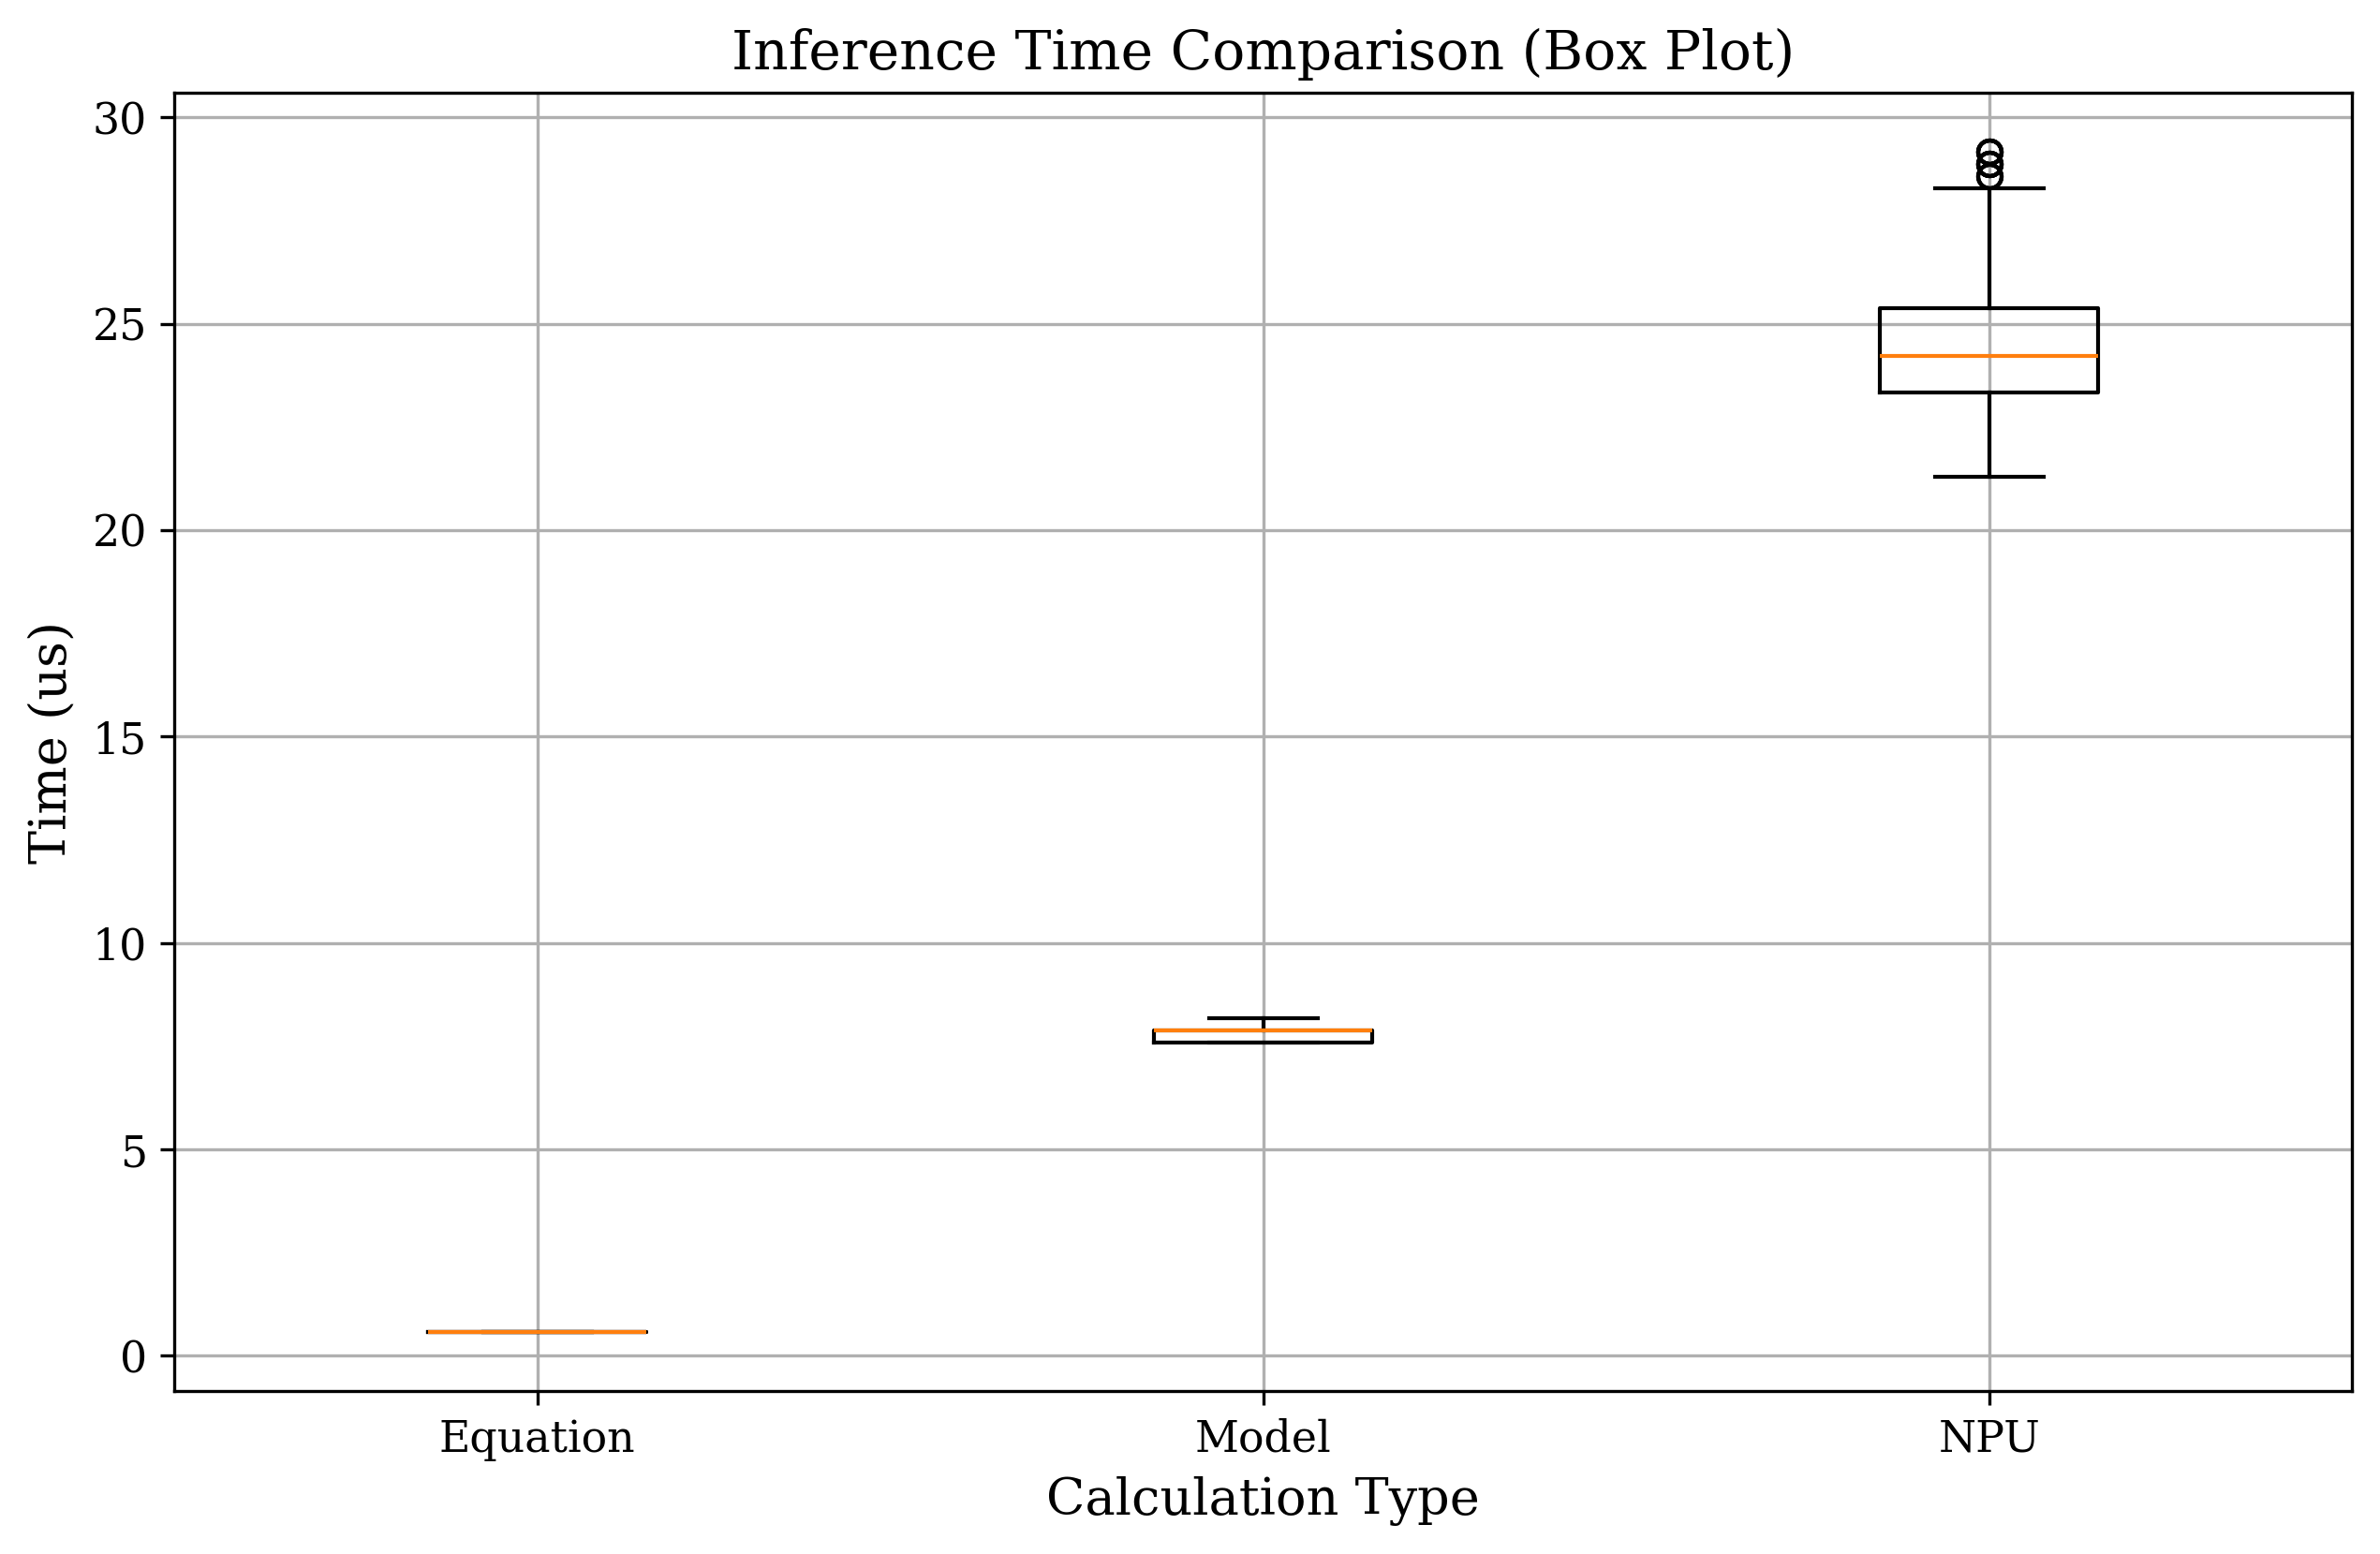

In [55]:
from matplotlib import pyplot as plt
plt.rcParams.update({
        "font.size": 12,
        "font.family": "serif",
        "axes.titlesize": 14,
        "axes.labelsize": 13,
        "legend.fontsize": 11,
        "xtick.labelsize": 11,
        "ytick.labelsize": 11,
        "figure.dpi": 300
    })
def remove_outliers_iqr(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data >= lower_bound) & (data <= upper_bound)]

# Remove outliers from both datasets
time_us_normal_filtered = remove_outliers_iqr(time_us_normal)
time_us_npu_filtered = remove_outliers_iqr(time_us_npu)
time_us_model_filtered = remove_outliers_iqr(time_us_model)

# Plotting
plt.figure(figsize=(10, 6))
plt.boxplot([time_us_normal_filtered,time_us_model_filtered, time_us_npu_filtered], tick_labels=["Equation","Model","NPU"])
plt.xlabel("Calculation Type")
plt.ylabel("Time (us)")
plt.title("Inference Time Comparison (Box Plot)")
plt.grid(True)
plt.show()

In [44]:
print(os.listdir("/content"))

['.config', 'output.txt', 'output_normal.txt', 'normal_model.h5', 'wandb', 'sample_data']


In [45]:
model.load_weights("/content/normal_model.h5")

In [46]:
weights = model.get_weights()

W1, b1 = weights[0], weights[1]   # (2, 8), (8,)
W2, b2 = weights[2], weights[3]   # (8,16), (16,)
W3, b3 = weights[4], weights[5]   # (16,1), (1,)


In [47]:
def c_array(name, arr):
    flat = arr.flatten()
    print(f"float {name}[{len(flat)}] = {{")
    print(", ".join(f"{x:.6f}f" for x in flat))
    print("};\n")

c_array("W1", W1)
c_array("b1", b1)
c_array("W2", W2)
c_array("b2", b2)
c_array("W3", W3)
c_array("b3", b3)


float W1[16] = {
0.137035f, -0.091562f, -0.556704f, 0.019155f, -0.161019f, -0.017937f, -0.306512f, 0.864718f, -0.330848f, 0.281924f, -0.532878f, -0.341697f, 0.577816f, 0.048100f, -0.169954f, 0.443168f
};

float b1[8] = {
0.247076f, -0.010449f, 0.000000f, -0.021452f, -0.020286f, -0.047487f, 0.000000f, -0.138814f
};

float W2[128] = {
-0.028488f, -0.312762f, 0.339321f, 0.451213f, 0.138466f, -0.460974f, -0.024100f, 0.264286f, -0.435933f, -0.283501f, -0.148148f, -0.233364f, 0.103016f, -0.322032f, -0.479543f, -0.067806f, -0.540677f, 0.227184f, -0.758702f, 0.173562f, -0.553398f, -0.145810f, 0.142089f, -0.612877f, 0.132478f, -0.238455f, 0.421089f, 0.388299f, -0.075838f, -0.211295f, 0.011788f, -0.066206f, 0.368206f, -0.357022f, -0.218328f, -0.426850f, 0.118410f, 0.228729f, -0.101586f, 0.104666f, 0.400147f, -0.005330f, -0.287854f, -0.185351f, -0.460494f, 0.094882f, -0.290713f, -0.418208f, 0.053260f, -0.051573f, 0.106139f, 0.495934f, -0.359359f, 0.325669f, 0.117595f, 0.053897f, -0.368324f, 0.451